<a href="https://colab.research.google.com/github/MarawanEldeib/FYP-Mango-Fruit-Detection-From-Aerial-Image/blob/main/Fyp_part_1_mango_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# In cocoeval.py to get the thresholds of IoU @0.2 according to the paper
#Line 461
#stats[1] = _summarize(1, iouThr=.2, maxDets=self.params.maxDets[2])
#Line 466
#stats[6] = _summarize(0, iouThr=.2, maxDets=self.params.maxDets[2])
#Line 506
#self.iouThrs = np.linspace(.2, 1, int(np.round((1 - .2) / .05)) + 1, endpoint=True)

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
print(torch.__version__)

Looking in indexes: https://download.pytorch.org/whl/cu121
2.1.0+cu121


In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.8.2
!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../
!pip install pycocotools
from pycocotools.cocoeval import COCOeval
%cd ..


Cloning into 'vision'...
remote: Enumerating objects: 461195, done.
remote: Counting objects: 100% (41654/41654), done.
remote: Compressing objects: 100% (1956/1956), done.
remote: Total 461195 (delta 39726), reused 41505 (delta 39636), pack-reused 419541
Receiving objects: 100% (461195/461195), 905.67 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (428829/428829), done.
/content/vision
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to

In [ ]:
# /usr/local/lib/python3.10/dist-packages/pycocotools/cocoeval.py


In [ ]:
import pycocotools
import os
new_dir = '/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/vision/references/detection'
os.makedirs(new_dir, exist_ok=True)
dir = r'/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/vision/references/detection'
os.chdir(dir)

In [ ]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import PIL
from PIL import Image, ImageDraw
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
import utils
import os,sys
from torchvision import transforms as T
#import transforms as T
#import original_transforms as T2
import custom_transforms as T2

In [ ]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["x", "y", "dx_new", "dy_new"]].values
    return boxes_array

In [ ]:
# Define the datset class. This loads the path to the images and path to the csv file with dimensions of bounding boxes
class FruitDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):

        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(self.root))
        self.path_to_data_file = data_file


    def __getitem__(self, idx):

        # load images and bounding boxes

        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        box_list = parse_one_annot(self.path_to_data_file,self.imgs[idx][:-4])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = FruitDataset(root= r"/content/drive/MyDrive/mangoes/train_images",
data_file= r"/content/drive/MyDrive/mangoes/combined_csv.csv")
dataset.__getitem__(1)

(<PIL.Image.Image image mode=RGB size=500x500>,
 {'boxes': tensor([[273.0000, 344.0000, 320.1590, 391.1590],
          [248.0000, 356.0000, 295.1590, 403.1590],
          [373.0000, 395.0000, 420.1590, 442.1590],
          [391.0000, 418.0000, 438.1590, 465.1590],
          [332.6316, 381.5789, 364.6316, 424.1710],
          [327.3684, 267.3684, 355.8804, 298.4180],
          [344.7368, 242.1053, 376.1000, 283.4323]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([1]),
  'area': tensor([2223.9680, 2223.9680, 2223.9680, 2223.9680, 1362.9443,  885.2867,
          1296.1459]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])})

In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
def get_model(num_classes):
    # Load a pre-trained ResNet-50 backbone with FPN
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    backbone.out_channels = 256

    # Anchor sizes and aspect ratios per feature map level
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

    anchor_generator = AnchorGenerator(
        sizes=anchor_sizes,
        aspect_ratios=aspect_ratios
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

   # def get_model(num_classes):

    #Selecting the pretrained VGG16 faster-RCNN as the backbone model


    #backbone = torchvision.models.vgg16(pretrained=True).features
    #backbone.out_channels = 512

    #anchor_generator = AnchorGenerator(sizes=(( 64, 128,256),), aspect_ratios=((0.5, 1.0, 2.0),))

    #roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)

    #model = FasterRCNN(backbone,num_classes=2, rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler)

    #return model


In [ ]:
class CustomCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target=None):
        for t in self.transforms:
            if isinstance(t, (T2.RandomHorizontalFlip, T2.Resize)):  # Add T2.RandomGrayscale if using it
                img, target = t(img, target)
            else:
                img = t(img)
        return img, target

def get_transform(train):

    transform_list = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transform_list.append(T.ToTensor())
    if train:
      #Flip transform- images are flipped with 0.5 probability
      transform_list.append(T2.RandomHorizontalFlip(0.5))
      #Scale transform to 300x300
      transform_list.append(T2.Resize(size = 300))

      #Convert images to grayscale with a probability of 0.2
      #transform_list.append(T.RandomGrayscale(0.2))

    return CustomCompose(transform_list)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [ ]:
dataset = FruitDataset(root= r"/content/drive/MyDrive/mangoes/train_images",
data_file= r"/content/drive/MyDrive/mangoes/combined_csv.csv",transforms = get_transform(train=True))

dataset_test = FruitDataset(root= r"/content/drive/MyDrive/mangoes/test_images",
          data_file= r"/content/drive/MyDrive/mangoes/combined_test/combined_test_csv.csv",
               transforms = get_transform(train=False))
#Random seed value
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

#Choose a subset from the training dataset
dataset_subset = torch.utils.data.Subset(dataset,indices[:500])

data_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=True, num_workers=2,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=1,collate_fn=utils.collate_fn)

print("Train dataset: ", len(data_loader), " \nTest dataset length",len(data_loader_test))
dataset.__getitem__(1)

Train dataset:  500  
Test dataset length 250


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[0.3063, 0.3059, 0.3041,  ..., 0.3525, 0.3268, 0.3473],
          [0.2928, 0.2863, 0.2915,  ..., 0.3268, 0.3529, 0.3660],
          [0.3050, 0.3085, 0.3107,  ..., 0.3464, 0.3373, 0.3490],
          ...,
          [0.2061, 0.1830, 0.2074,  ..., 0.1115, 0.1216, 0.1359],
          [0.1817, 0.1922, 0.2118,  ..., 0.0967, 0.1255, 0.1386],
          [0.1634, 0.1856, 0.2065,  ..., 0.1024, 0.1255, 0.1368]],
 
         [[0.2571, 0.2484, 0.2519,  ..., 0.2989, 0.2941, 0.2932],
          [0.2444, 0.2431, 0.2431,  ..., 0.2941, 0.2902, 0.2941],
          [0.2558, 0.2549, 0.2514,  ..., 0.2946, 0.2863, 0.2993],
          ...,
          [0.1756, 0.1804, 0.1991,  ..., 0.0902, 0.0889, 0.1085],
          [0.1595, 0.1804, 0.1948,  ..., 0.0837, 0.0941, 0.1085],
          [0.1564, 0.1804, 0.2013,  ..., 0.0898, 0.0980, 0.1224]],
 
         [[0.3216, 0.3346, 0.3303,  ..., 0.3795, 0.3778, 0.3730],
          [0.3216, 0.3255, 0.3320,  ..., 0.3830, 0.3765, 0.3712],
          [0.3294, 0.3216, 0.3333,  ...,

In [ ]:
#Check if GPU is available
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0')
# Our dataset has two classes only - mango and not mango
num_classes = 2
# Get the model using our helper function
model = get_model(num_classes)
# Move model to the right device
model.to(device)
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# A learning rate scheduler which decreases the learning rate by # 10x every 5 epochs. Change this value based on the dataset size
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

In [ ]:
import os

# Number of epochs to train for
num_epochs = 20

for epoch in range(num_epochs):
    # Train for one epoch
    torch.cuda.empty_cache()
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=500)

    # Update the learning rate
    lr_scheduler.step()

    # Save the model every 2 epochs
    if (epoch % 2) == 0:
        save_path = r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_flip_scale_size500_frthtry"
        # Create the directory if it does not exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(model.state_dict(), save_path)

    # Evaluate the model on test set every 2 epochs
    if (epoch % 2) == 0:
        evaluate(model, data_loader_test, device=device)

# Save the model after training
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)

# Evaluate on the test dataset after training
evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [0]  [  0/500]  eta: 0:03:39  lr: 0.000015  loss: 0.0010 (0.0010)  loss_classifier: 0.0003 (0.0003)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4400  data: 0.1808  max mem: 2961


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [0]  [499/500]  eta: 0:00:00  lr: 0.005000  loss: 0.2880 (0.4967)  loss_classifier: 0.1506 (0.1637)  loss_box_reg: 0.1131 (0.2585)  loss_objectness: 0.0154 (0.0555)  loss_rpn_box_reg: 0.0045 (0.0190)  time: 0.2193  data: 0.0058  max mem: 2963
Epoch: [0] Total time: 0:01:45 (0.2102 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:00:55  model_time: 0.1259 (0.1259)  evaluator_time: 0.0053 (0.0053)  time: 0.2234  data: 0.0904  max mem: 2963
Test:  [100/250]  eta: 0:00:15  model_time: 0.0844 (0.0882)  evaluator_time: 0.0022 (0.0085)  time: 0.0934  data: 0.0035  max mem: 2963
Test:  [200/250]  eta: 0:00:05  model_time: 0.0865 (0.0874)  evaluator_time: 0.0016 (0.0075)  time: 0.0955  data: 0.0038  max mem: 2963
Test:  [249/250]  eta: 0:00:00  model_time: 0.0875 (0.0873)  evaluator_time: 0.0029 (0.0072)  time: 0.1002  data: 0.0060  max mem: 2963
Test: Total time: 0:00:25 (0.1022 s / it)
Averaged stats: model_time: 0.0875 (0.0873)  evaluator_time: 0.0029 (0.0072)
Accumul

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [1]  [  0/500]  eta: 0:03:36  lr: 0.005000  loss: 0.7242 (0.7242)  loss_classifier: 0.2192 (0.2192)  loss_box_reg: 0.4573 (0.4573)  loss_objectness: 0.0303 (0.0303)  loss_rpn_box_reg: 0.0174 (0.0174)  time: 0.4334  data: 0.2028  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [1]  [499/500]  eta: 0:00:00  lr: 0.005000  loss: 0.3693 (0.4657)  loss_classifier: 0.1103 (0.1635)  loss_box_reg: 0.1750 (0.2361)  loss_objectness: 0.0508 (0.0494)  loss_rpn_box_reg: 0.0093 (0.0167)  time: 0.2037  data: 0.0035  max mem: 2963
Epoch: [1] Total time: 0:01:44 (0.2088 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [2]  [  0/500]  eta: 0:03:23  lr: 0.005000  loss: 0.1976 (0.1976)  loss_classifier: 0.0485 (0.0485)  loss_box_reg: 0.1421 (0.1421)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 0.4080  data: 0.1930  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [2]  [499/500]  eta: 0:00:00  lr: 0.005000  loss: 0.4934 (0.4229)  loss_classifier: 0.1620 (0.1410)  loss_box_reg: 0.3199 (0.2156)  loss_objectness: 0.0270 (0.0485)  loss_rpn_box_reg: 0.0109 (0.0179)  time: 0.2099  data: 0.0067  max mem: 2963
Epoch: [2] Total time: 0:01:45 (0.2117 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:14  model_time: 0.1512 (0.1512)  evaluator_time: 0.0069 (0.0069)  time: 0.2971  data: 0.1326  max mem: 2963
Test:  [100/250]  eta: 0:00:15  model_time: 0.0840 (0.0869)  evaluator_time: 0.0016 (0.0052)  time: 0.0924  data: 0.0038  max mem: 2963
Test:  [200/250]  eta: 0:00:04  model_time: 0.0869 (0.0867)  evaluator_time: 0.0011 (0.0046)  time: 0.0939  data: 0.0035  max mem: 2963
Test:  [249/250]  eta: 0:00:00  model_time: 0.0871 (0.0867)  evaluator_time: 0.0014 (0.0042)  time: 0.0951  data: 0.0036  max mem: 2963
Test: Total time: 0:00:24 (0.0991 s / it)
Averaged stats: model_time: 0.0871 (0.0867)  evaluator_time: 0.0014 (0.0042)
Accumul

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [3]  [  0/500]  eta: 0:04:59  lr: 0.005000  loss: 0.0045 (0.0045)  loss_classifier: 0.0026 (0.0026)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5984  data: 0.3057  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [3]  [499/500]  eta: 0:00:00  lr: 0.005000  loss: 0.4013 (0.3818)  loss_classifier: 0.1304 (0.1287)  loss_box_reg: 0.2381 (0.2071)  loss_objectness: 0.0100 (0.0339)  loss_rpn_box_reg: 0.0094 (0.0121)  time: 0.2034  data: 0.0035  max mem: 2963
Epoch: [3] Total time: 0:01:44 (0.2097 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [4]  [  0/500]  eta: 0:03:29  lr: 0.005000  loss: 0.0501 (0.0501)  loss_classifier: 0.0403 (0.0403)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0099 (0.0099)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4190  data: 0.1810  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [4]  [499/500]  eta: 0:00:00  lr: 0.005000  loss: 0.1509 (0.3375)  loss_classifier: 0.0607 (0.1125)  loss_box_reg: 0.0789 (0.1933)  loss_objectness: 0.0065 (0.0219)  loss_rpn_box_reg: 0.0027 (0.0098)  time: 0.2150  data: 0.0054  max mem: 2963
Epoch: [4] Total time: 0:01:45 (0.2102 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:42  model_time: 0.1814 (0.1814)  evaluator_time: 0.0167 (0.0167)  time: 0.4099  data: 0.2101  max mem: 2963
Test:  [100/250]  eta: 0:00:15  model_time: 0.0845 (0.0873)  evaluator_time: 0.0015 (0.0046)  time: 0.0917  data: 0.0035  max mem: 2963
Test:  [200/250]  eta: 0:00:04  model_time: 0.0863 (0.0871)  evaluator_time: 0.0012 (0.0042)  time: 0.0936  data: 0.0037  max mem: 2963
Test:  [249/250]  eta: 0:00:00  model_time: 0.0872 (0.0871)  evaluator_time: 0.0019 (0.0038)  time: 0.0949  data: 0.0036  max mem: 2963
Test: Total time: 0:00:24 (0.0983 s / it)
Averaged stats: model_time: 0.0872 (0.0871)  evaluator_time: 0.0019 (0.0038)
Accumul

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [5]  [  0/500]  eta: 0:03:42  lr: 0.000500  loss: 0.7037 (0.7037)  loss_classifier: 0.2604 (0.2604)  loss_box_reg: 0.4172 (0.4172)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0148 (0.0148)  time: 0.4454  data: 0.2137  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [5]  [499/500]  eta: 0:00:00  lr: 0.000500  loss: 0.2345 (0.2817)  loss_classifier: 0.0884 (0.0926)  loss_box_reg: 0.1524 (0.1678)  loss_objectness: 0.0049 (0.0143)  loss_rpn_box_reg: 0.0019 (0.0071)  time: 0.2038  data: 0.0036  max mem: 2963
Epoch: [5] Total time: 0:01:45 (0.2111 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [6]  [  0/500]  eta: 0:03:28  lr: 0.000500  loss: 0.0088 (0.0088)  loss_classifier: 0.0072 (0.0072)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4163  data: 0.1867  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [6]  [499/500]  eta: 0:00:00  lr: 0.000500  loss: 0.2059 (0.2747)  loss_classifier: 0.0664 (0.0886)  loss_box_reg: 0.1245 (0.1683)  loss_objectness: 0.0030 (0.0111)  loss_rpn_box_reg: 0.0021 (0.0067)  time: 0.2172  data: 0.0066  max mem: 2963
Epoch: [6] Total time: 0:01:45 (0.2101 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:15  model_time: 0.1336 (0.1336)  evaluator_time: 0.0052 (0.0052)  time: 0.3023  data: 0.1595  max mem: 2963
Test:  [100/250]  eta: 0:00:14  model_time: 0.0834 (0.0865)  evaluator_time: 0.0011 (0.0041)  time: 0.0916  data: 0.0036  max mem: 2963
Test:  [200/250]  eta: 0:00:04  model_time: 0.0879 (0.0867)  evaluator_time: 0.0011 (0.0037)  time: 0.1006  data: 0.0077  max mem: 2963
Test:  [249/250]  eta: 0:00:00  model_time: 0.0876 (0.0878)  evaluator_time: 0.0017 (0.0037)  time: 0.0975  data: 0.0055  max mem: 2963
Test: Total time: 0:00:25 (0.1003 s / it)
Averaged stats: model_time: 0.0876 (0.0878)  evaluator_time: 0.0017 (0.0037)
Accumul

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [7]  [  0/500]  eta: 0:03:51  lr: 0.000500  loss: 0.2920 (0.2920)  loss_classifier: 0.1085 (0.1085)  loss_box_reg: 0.1547 (0.1547)  loss_objectness: 0.0172 (0.0172)  loss_rpn_box_reg: 0.0115 (0.0115)  time: 0.4635  data: 0.2023  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [7]  [499/500]  eta: 0:00:00  lr: 0.000500  loss: 0.2168 (0.2690)  loss_classifier: 0.0678 (0.0859)  loss_box_reg: 0.1422 (0.1656)  loss_objectness: 0.0060 (0.0109)  loss_rpn_box_reg: 0.0030 (0.0066)  time: 0.2163  data: 0.0052  max mem: 2963
Epoch: [7] Total time: 0:01:46 (0.2124 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [8]  [  0/500]  eta: 0:03:33  lr: 0.000500  loss: 0.0260 (0.0260)  loss_classifier: 0.0103 (0.0103)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0158 (0.0158)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4263  data: 0.2207  max mem: 2963


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [8]  [499/500]  eta: 0:00:00  lr: 0.000500  loss: 0.2533 (0.2666)  loss_classifier: 0.0811 (0.0854)  loss_box_reg: 0.1618 (0.1639)  loss_objectness: 0.0024 (0.0110)  loss_rpn_box_reg: 0.0024 (0.0063)  time: 0.2106  data: 0.0050  max mem: 2964
Epoch: [8] Total time: 0:01:46 (0.2135 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:22  model_time: 0.1531 (0.1531)  evaluator_time: 0.0055 (0.0055)  time: 0.3285  data: 0.1681  max mem: 2964
Test:  [100/250]  eta: 0:00:15  model_time: 0.0840 (0.0865)  evaluator_time: 0.0013 (0.0051)  time: 0.0909  data: 0.0036  max mem: 2964
Test:  [200/250]  eta: 0:00:05  model_time: 0.0867 (0.0874)  evaluator_time: 0.0010 (0.0047)  time: 0.0930  data: 0.0035  max mem: 2964
Test:  [249/250]  eta: 0:00:00  model_time: 0.0864 (0.0873)  evaluator_time: 0.0016 (0.0042)  time: 0.0941  data: 0.0038  max mem: 2964
Test: Total time: 0:00:24 (0.0990 s / it)
Averaged stats: model_time: 0.0864 (0.0873)  evaluator_time: 0.0016 (0.0042)
Accumul

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [9]  [  0/500]  eta: 0:05:29  lr: 0.000500  loss: 0.3010 (0.3010)  loss_classifier: 0.0999 (0.0999)  loss_box_reg: 0.1813 (0.1813)  loss_objectness: 0.0100 (0.0100)  loss_rpn_box_reg: 0.0098 (0.0098)  time: 0.6599  data: 0.3627  max mem: 2964


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [9]  [499/500]  eta: 0:00:00  lr: 0.000500  loss: 0.3210 (0.2616)  loss_classifier: 0.1132 (0.0826)  loss_box_reg: 0.1823 (0.1634)  loss_objectness: 0.0064 (0.0094)  loss_rpn_box_reg: 0.0049 (0.0062)  time: 0.2046  data: 0.0035  max mem: 2964
Epoch: [9] Total time: 0:01:46 (0.2140 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [10]  [  0/500]  eta: 0:05:33  lr: 0.000050  loss: 0.0150 (0.0150)  loss_classifier: 0.0148 (0.0148)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6678  data: 0.3313  max mem: 2964


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [10]  [499/500]  eta: 0:00:00  lr: 0.000050  loss: 0.1903 (0.2535)  loss_classifier: 0.0705 (0.0801)  loss_box_reg: 0.1126 (0.1594)  loss_objectness: 0.0026 (0.0079)  loss_rpn_box_reg: 0.0020 (0.0061)  time: 0.2186  data: 0.0068  max mem: 2964
Epoch: [10] Total time: 0:01:45 (0.2118 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:14  model_time: 0.1448 (0.1448)  evaluator_time: 0.0110 (0.0110)  time: 0.2968  data: 0.1391  max mem: 2964
Test:  [100/250]  eta: 0:00:14  model_time: 0.0838 (0.0869)  evaluator_time: 0.0012 (0.0039)  time: 0.0909  data: 0.0036  max mem: 2964
Test:  [200/250]  eta: 0:00:05  model_time: 0.0872 (0.0877)  evaluator_time: 0.0012 (0.0042)  time: 0.0984  data: 0.0049  max mem: 2964
Test:  [249/250]  eta: 0:00:00  model_time: 0.0867 (0.0880)  evaluator_time: 0.0013 (0.0040)  time: 0.0940  data: 0.0036  max mem: 2964
Test: Total time: 0:00:25 (0.1014 s / it)
Averaged stats: model_time: 0.0867 (0.0880)  evaluator_time: 0.0013 (0.0040)
Accum

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [11]  [  0/500]  eta: 0:03:49  lr: 0.000050  loss: 0.3139 (0.3139)  loss_classifier: 0.0991 (0.0991)  loss_box_reg: 0.2122 (0.2122)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 0.4589  data: 0.2389  max mem: 2964


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [11]  [499/500]  eta: 0:00:00  lr: 0.000050  loss: 0.3420 (0.2529)  loss_classifier: 0.0876 (0.0799)  loss_box_reg: 0.2317 (0.1592)  loss_objectness: 0.0046 (0.0078)  loss_rpn_box_reg: 0.0074 (0.0059)  time: 0.2115  data: 0.0064  max mem: 2965
Epoch: [11] Total time: 0:01:45 (0.2114 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [12]  [  0/500]  eta: 0:04:47  lr: 0.000050  loss: 0.0010 (0.0010)  loss_classifier: 0.0007 (0.0007)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5757  data: 0.3027  max mem: 2965


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [12]  [499/500]  eta: 0:00:00  lr: 0.000050  loss: 0.2440 (0.2517)  loss_classifier: 0.0722 (0.0798)  loss_box_reg: 0.1578 (0.1574)  loss_objectness: 0.0017 (0.0087)  loss_rpn_box_reg: 0.0033 (0.0059)  time: 0.2041  data: 0.0033  max mem: 2965
Epoch: [12] Total time: 0:01:45 (0.2115 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:04  model_time: 0.1265 (0.1265)  evaluator_time: 0.0029 (0.0029)  time: 0.2597  data: 0.1285  max mem: 2965
Test:  [100/250]  eta: 0:00:14  model_time: 0.0908 (0.0856)  evaluator_time: 0.0025 (0.0035)  time: 0.1090  data: 0.0128  max mem: 2965
Test:  [200/250]  eta: 0:00:04  model_time: 0.0862 (0.0870)  evaluator_time: 0.0009 (0.0038)  time: 0.0932  data: 0.0037  max mem: 2965
Test:  [249/250]  eta: 0:00:00  model_time: 0.0887 (0.0871)  evaluator_time: 0.0017 (0.0035)  time: 0.0973  data: 0.0038  max mem: 2965
Test: Total time: 0:00:24 (0.0992 s / it)
Averaged stats: model_time: 0.0887 (0.0871)  evaluator_time: 0.0017 (0.0035)
Accum

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [13]  [  0/500]  eta: 0:05:35  lr: 0.000050  loss: 0.6389 (0.6389)  loss_classifier: 0.2211 (0.2211)  loss_box_reg: 0.3802 (0.3802)  loss_objectness: 0.0158 (0.0158)  loss_rpn_box_reg: 0.0218 (0.0218)  time: 0.6718  data: 0.3468  max mem: 2965


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [13]  [499/500]  eta: 0:00:00  lr: 0.000050  loss: 0.1865 (0.2508)  loss_classifier: 0.0771 (0.0787)  loss_box_reg: 0.1201 (0.1584)  loss_objectness: 0.0035 (0.0078)  loss_rpn_box_reg: 0.0026 (0.0059)  time: 0.2144  data: 0.0058  max mem: 2965
Epoch: [13] Total time: 0:01:46 (0.2128 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [14]  [  0/500]  eta: 0:04:29  lr: 0.000050  loss: 0.4651 (0.4651)  loss_classifier: 0.1558 (0.1558)  loss_box_reg: 0.3003 (0.3003)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 0.5382  data: 0.2287  max mem: 2965


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [14]  [499/500]  eta: 0:00:00  lr: 0.000050  loss: 0.2059 (0.2528)  loss_classifier: 0.0598 (0.0797)  loss_box_reg: 0.1168 (0.1589)  loss_objectness: 0.0018 (0.0085)  loss_rpn_box_reg: 0.0013 (0.0059)  time: 0.2091  data: 0.0042  max mem: 3025
Epoch: [14] Total time: 0:01:45 (0.2117 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:30  model_time: 0.1565 (0.1565)  evaluator_time: 0.0082 (0.0082)  time: 0.3632  data: 0.1963  max mem: 3025
Test:  [100/250]  eta: 0:00:16  model_time: 0.0832 (0.0903)  evaluator_time: 0.0012 (0.0050)  time: 0.0912  data: 0.0037  max mem: 3025
Test:  [200/250]  eta: 0:00:05  model_time: 0.0867 (0.0885)  evaluator_time: 0.0009 (0.0041)  time: 0.0937  data: 0.0035  max mem: 3025
Test:  [249/250]  eta: 0:00:00  model_time: 0.0873 (0.0882)  evaluator_time: 0.0016 (0.0037)  time: 0.0945  data: 0.0036  max mem: 3025
Test: Total time: 0:00:25 (0.1006 s / it)
Averaged stats: model_time: 0.0873 (0.0882)  evaluator_time: 0.0016 (0.0037)
Accum

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [15]  [  0/500]  eta: 0:05:52  lr: 0.000005  loss: 1.8739 (1.8739)  loss_classifier: 0.6270 (0.6270)  loss_box_reg: 0.5817 (0.5817)  loss_objectness: 0.4839 (0.4839)  loss_rpn_box_reg: 0.1813 (0.1813)  time: 0.7043  data: 0.3396  max mem: 3025


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [15]  [499/500]  eta: 0:00:00  lr: 0.000005  loss: 0.2548 (0.2501)  loss_classifier: 0.0716 (0.0779)  loss_box_reg: 0.1746 (0.1583)  loss_objectness: 0.0044 (0.0081)  loss_rpn_box_reg: 0.0030 (0.0058)  time: 0.2098  data: 0.0041  max mem: 3025
Epoch: [15] Total time: 0:01:46 (0.2132 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [16]  [  0/500]  eta: 0:05:05  lr: 0.000005  loss: 0.0009 (0.0009)  loss_classifier: 0.0006 (0.0006)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6119  data: 0.3464  max mem: 3025


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [16]  [499/500]  eta: 0:00:00  lr: 0.000005  loss: 0.3202 (0.2516)  loss_classifier: 0.0833 (0.0790)  loss_box_reg: 0.1906 (0.1592)  loss_objectness: 0.0028 (0.0076)  loss_rpn_box_reg: 0.0061 (0.0058)  time: 0.2185  data: 0.0065  max mem: 3025
Epoch: [16] Total time: 0:01:46 (0.2133 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:09  model_time: 0.1326 (0.1326)  evaluator_time: 0.0044 (0.0044)  time: 0.2780  data: 0.1389  max mem: 3025
Test:  [100/250]  eta: 0:00:14  model_time: 0.0835 (0.0858)  evaluator_time: 0.0013 (0.0041)  time: 0.0907  data: 0.0036  max mem: 3025
Test:  [200/250]  eta: 0:00:04  model_time: 0.0863 (0.0862)  evaluator_time: 0.0012 (0.0038)  time: 0.0991  data: 0.0067  max mem: 3025
Test:  [249/250]  eta: 0:00:00  model_time: 0.0866 (0.0872)  evaluator_time: 0.0013 (0.0038)  time: 0.1001  data: 0.0083  max mem: 3025
Test: Total time: 0:00:24 (0.0993 s / it)
Averaged stats: model_time: 0.0866 (0.0872)  evaluator_time: 0.0013 (0.0038)
Accum

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [17]  [  0/500]  eta: 0:03:52  lr: 0.000005  loss: 0.0526 (0.0526)  loss_classifier: 0.0518 (0.0518)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4641  data: 0.2008  max mem: 3025


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [17]  [499/500]  eta: 0:00:00  lr: 0.000005  loss: 0.3410 (0.2511)  loss_classifier: 0.0959 (0.0791)  loss_box_reg: 0.2097 (0.1579)  loss_objectness: 0.0016 (0.0082)  loss_rpn_box_reg: 0.0033 (0.0059)  time: 0.2105  data: 0.0080  max mem: 3025
Epoch: [17] Total time: 0:01:46 (0.2125 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [18]  [  0/500]  eta: 0:04:31  lr: 0.000005  loss: 0.1115 (0.1115)  loss_classifier: 0.0414 (0.0414)  loss_box_reg: 0.0638 (0.0638)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 0.5422  data: 0.2391  max mem: 3025


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [18]  [499/500]  eta: 0:00:00  lr: 0.000005  loss: 0.2244 (0.2517)  loss_classifier: 0.0745 (0.0786)  loss_box_reg: 0.1404 (0.1589)  loss_objectness: 0.0031 (0.0084)  loss_rpn_box_reg: 0.0032 (0.0058)  time: 0.2031  data: 0.0036  max mem: 3025
Epoch: [18] Total time: 0:01:46 (0.2127 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:02  model_time: 0.1290 (0.1290)  evaluator_time: 0.0028 (0.0028)  time: 0.2500  data: 0.1166  max mem: 3025
Test:  [100/250]  eta: 0:00:14  model_time: 0.0866 (0.0854)  evaluator_time: 0.0014 (0.0034)  time: 0.1014  data: 0.0080  max mem: 3025
Test:  [200/250]  eta: 0:00:05  model_time: 0.0855 (0.0875)  evaluator_time: 0.0009 (0.0040)  time: 0.0925  data: 0.0036  max mem: 3025
Test:  [249/250]  eta: 0:00:00  model_time: 0.0880 (0.0875)  evaluator_time: 0.0019 (0.0037)  time: 0.0996  data: 0.0063  max mem: 3025
Test: Total time: 0:00:24 (0.0994 s / it)
Averaged stats: model_time: 0.0880 (0.0875)  evaluator_time: 0.0019 (0.0037)
Accum

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [19]  [  0/500]  eta: 0:05:16  lr: 0.000005  loss: 0.0093 (0.0093)  loss_classifier: 0.0078 (0.0078)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6323  data: 0.2991  max mem: 3025


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [19]  [499/500]  eta: 0:00:00  lr: 0.000005  loss: 0.1570 (0.2502)  loss_classifier: 0.0606 (0.0780)  loss_box_reg: 0.1096 (0.1575)  loss_objectness: 0.0022 (0.0089)  loss_rpn_box_reg: 0.0019 (0.0058)  time: 0.2094  data: 0.0046  max mem: 3025
Epoch: [19] Total time: 0:01:46 (0.2139 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:03  model_time: 0.1274 (0.1274)  evaluator_time: 0.0028 (0.0028)  time: 0.2555  data: 0.1235  max mem: 3025
Test:  [100/250]  eta: 0:00:16  model_time: 0.0839 (0.0914)  evaluator_time: 0.0016 (0.0063)  time: 0.0985  data: 0.0064  max mem: 3025
Test:  [200/250]  eta: 0:00:05  model_time: 0.0888 (0.0887)  evaluator_time: 0.0014 (0.0046)  time: 0.1028  data: 0.0096  max mem: 3025
Test:  [249/250]  eta: 0:00:00  model_time: 0.0872 (0.0883)  evaluator_time: 0.0013 (0.0040)  time: 0.0940  data: 0.0035  max mem: 3025
Test: Total time: 0:00:25 (0.1010 s / it)
Averaged stats: model_time: 0.0872 (0.0883)  evaluator_time: 0.0013 (0.0040)
Accum

In [ ]:
#Load a saved model
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_flip_scale_size500"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]


<All keys matched successfully>

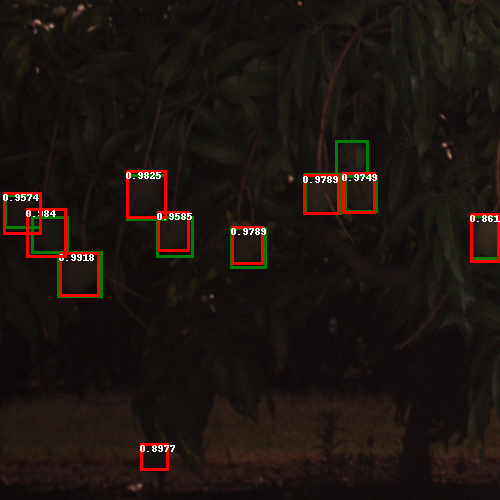

In [ ]:
idx = 200
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# Draw groundtruth box in Green
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])],
   outline ="green", width =3)

#Draw prediction box in Red
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)

   #Drawing prediction boxes above a certain confidence threshold
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image

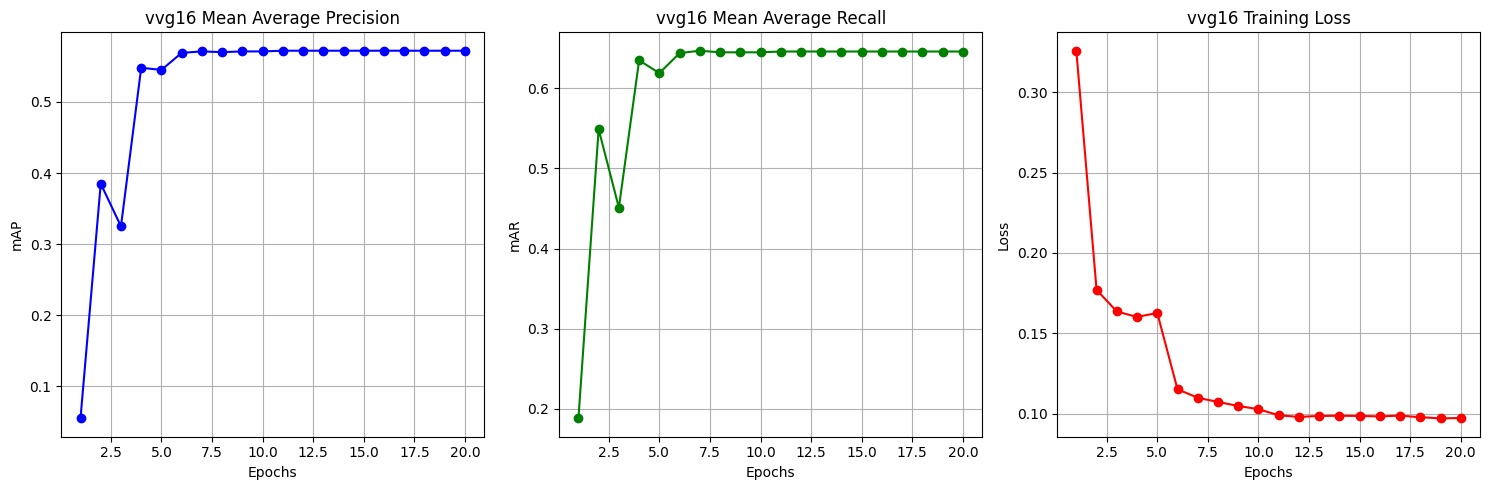

In [ ]:
import matplotlib.pyplot as plt

# Data for Model vvg16
epochs = list(range(1, 21))
map_values = [ 0.055, 0.385, 0.325, 0.548, 0.545, 0.569, 0.571, 0.570, 0.571, 0.571, 0.572 ]
mar_values = [ 0.188, 0.549, 0.451, 0.635, 0.619, 0.644, 0.647, 0.645, 0.645, 0.645, 0.646 ]
training_loss = [ 0.3258, 0.1770, 0.1635, 0.1601, 0.1626, 0.1151, 0.1098, 0.1072, 0.1047, 0.1027,
                   0.0989, 0.0979, 0.0985, 0.0986, 0.0985, 0.0982, 0.0987, 0.0977, 0.0970, 0.0972 ]

# Adjusting the length of map_values and mar_values to match the length of epochs
map_values += [map_values[-1]] * (len(epochs) - len(map_values))
mar_values += [mar_values[-1]] * (len(epochs) - len(mar_values))

# Plotting Mean Average Precision
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, map_values, marker='o', color='b')
plt.title('vvg16 Mean Average Precision')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.grid(True)

# Plotting Mean Average Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, mar_values, marker='o', color='g')
plt.title('vvg16 Mean Average Recall')
plt.xlabel('Epochs')
plt.ylabel('mAR')
plt.grid(True)

# Plotting Training Loss
plt.subplot(1, 3, 3)
plt.plot(epochs, training_loss, marker='o', color='r')
plt.title('vvg16 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


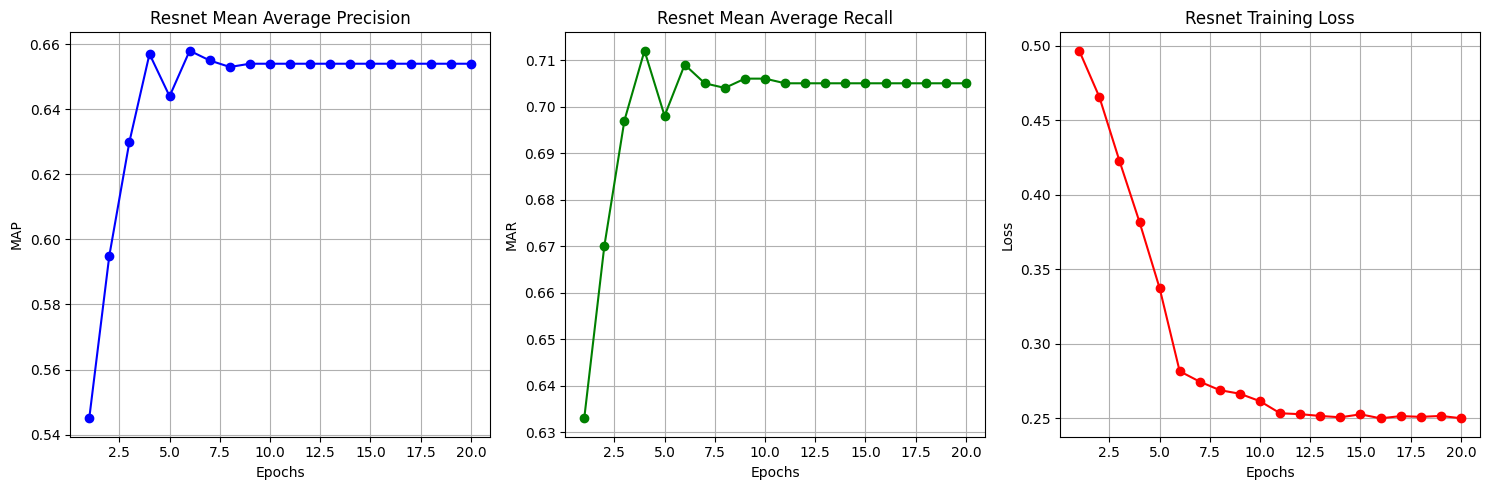

In [ ]:
import matplotlib.pyplot as plt

# Data for Resnet
epochs = list(range(1, 21))
map_values = [0.545, 0.595, 0.630, 0.657, 0.644, 0.658, 0.655, 0.653, 0.654, 0.654, 0.654]
mar_values = [0.633, 0.670, 0.697, 0.712, 0.698, 0.709, 0.705, 0.704, 0.706, 0.706, 0.705]
training_loss = [0.4967, 0.4657, 0.4229, 0.3818, 0.3375, 0.2817, 0.2747, 0.2690, 0.2666, 0.2616,
                  0.2535, 0.2529, 0.2517, 0.2508, 0.2528, 0.2501, 0.2516, 0.2511, 0.2517, 0.2502]

# Extend MAP and MAR values to match the length of epochs
map_values.extend([map_values[-1]] * (len(epochs) - len(map_values)))
mar_values.extend([mar_values[-1]] * (len(epochs) - len(mar_values)))

# Plotting Mean Average Precision
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, map_values, marker='o', color='b')
plt.title('Resnet Mean Average Precision')
plt.xlabel('Epochs')
plt.ylabel('MAP')
plt.grid(True)

# Plotting Mean Average Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, mar_values, marker='o', color='g')
plt.title('Resnet Mean Average Recall')
plt.xlabel('Epochs')
plt.ylabel('MAR')
plt.grid(True)

# Plotting Training Loss
plt.subplot(1, 3, 3)
plt.plot(epochs, training_loss, marker='o', color='r')
plt.title('Resnet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
